In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn.feature_extraction.image as skimage
import networkx as nx
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import DataLoader

In [2]:
# loading silhouettes and solutions
silhouettes = np.load("1_chunk_1_random_200_n_silhouttes.npy")
solutions = np.load("1_chunk_1_random_200_n_solutions.npy")

In [3]:
def get_bb_ids(silhouette):
    s = np.copy(silhouette)
    coords = np.argwhere(s==10)
    x_coords = [c[1] for c in coords]
    x_sorted = np.argsort(x_coords)
    s -= 1
    #s[s==0] = -1
    for i in x_sorted[:3]:
        s[coords[i][0],coords[i][1]] = 0
    for i in x_sorted[3:]:
        s[coords[i][0],coords[i][1]] = 1
    return s

In [4]:
def get_binary_silhouette(silhouette):
    binary = np.copy(silhouette)
    binary[binary>0]=1
    return binary

In [5]:
def get_neighborhood(point):
    x,y = point
    neighborhood = []
    neighborhood.append((x+1,y))
    neighborhood.append((x-1,y))
    neighborhood.append((x,y+1))
    neighborhood.append((x,y-1))
    return neighborhood

In [6]:
def get_fully_connected_graph():
    nodes = list(range(6))
    return [(i,j) for i in nodes for j in nodes if i!=j]

In [7]:
def build_graph(s):
    s = get_bb_ids(s)
    mappings = {}

    for c in np.unique(s):
        c = int(c)
        if c == -1:
            continue
        #print(c)
        points = np.argwhere(s==c)
        connecting_bb = set()
        for p in points:
            for (x,y) in get_neighborhood(p):
                n = s[x,y]
                if n != -1 and n!= c:
                    connecting_bb.add(int(n))
        mappings[c] = connecting_bb
    edges = []
    for k in mappings.keys():
        neighbors = mappings[k]
        for n in neighbors:
            edges.append((k,n))
    
    # remove permutations 
    return set(tuple(sorted(e)) for e in edges)

In [8]:
def draw_silhouette_color(s_color):
    cmap = plt.get_cmap('jet')
    # convert to rgba:

    norm = mpl.colors.Normalize(vmin=0, vmax=np.max(7))
    datan = norm(s_color)
    rgba = cmap(datan)

    # Fill in colours for the out of range data:

    rgba[s_color==-1, :] = [1, 1, 1, 1]
    rgba[s_color==3, :] = cmap(norm(4))
    rgba[s_color==4, :] = cmap(norm(6))
    rgba[s_color==5, :] = cmap(norm(7))
    rgba[s_color==2, :] = cmap(norm(3))
    
#     rgba[s_color==3, :] = cmap(norm(6))
#     

    plt.imshow(rgba)

In [9]:
def show_silhouette_and_graph(s):
    fig = plt.figure(figsize=(10,5))
    fig.add_subplot(1,2,1)
    draw_silhouette_color(get_bb_ids(s))
    #plt.imshow(get_bb_ids(s))

    fig.add_subplot(1,2,2)
    all_edges = get_fully_connected_graph()
    G = nx.Graph()
    G.add_edges_from(all_edges)
    pos = nx.spring_layout(G)
    con_edges = build_graph(s)
    values = list(range(6))

    pos = nx.spring_layout(G)
    inactive = [edge for edge in G.edges() if edge not in con_edges]
    nx.draw_networkx_nodes(G, pos,  node_color = values, node_size = 500, cmap=plt.get_cmap('jet'))
    nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_edges(G, pos, edgelist=con_edges, edge_color='r')
    nx.draw_networkx_edges(G, pos, edgelist=inactive, edge_color='gray')

    plt.show()

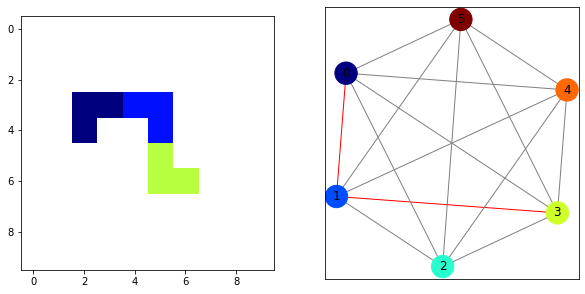

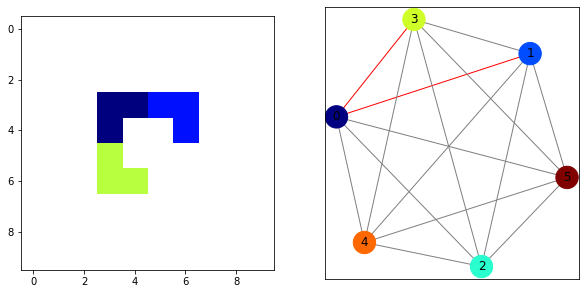

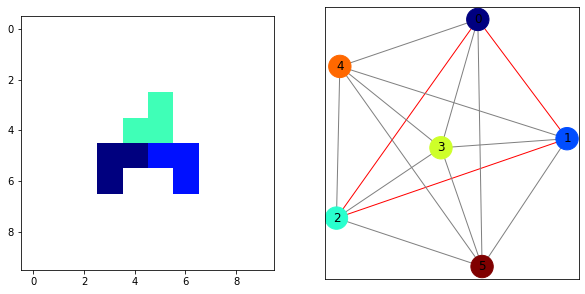

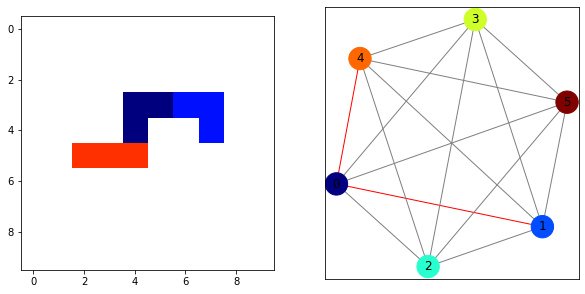

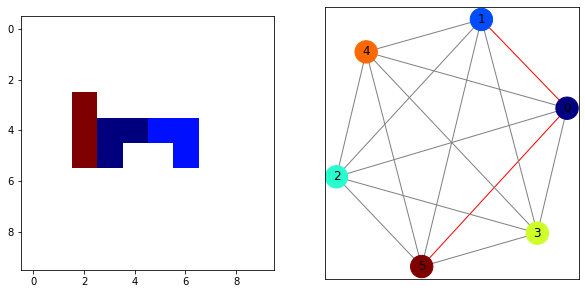

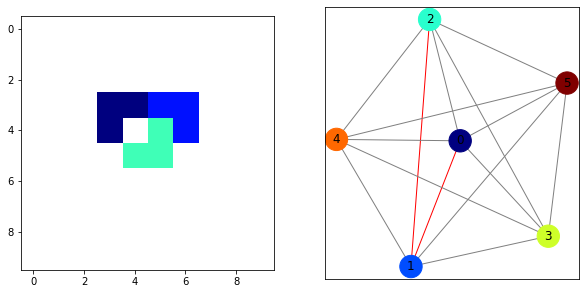

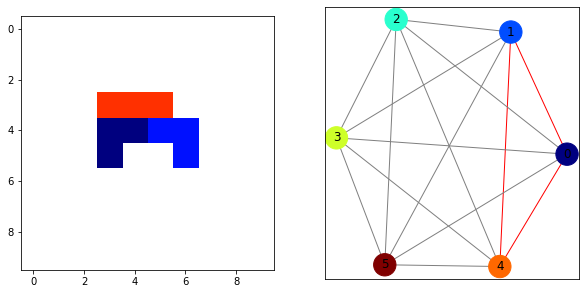

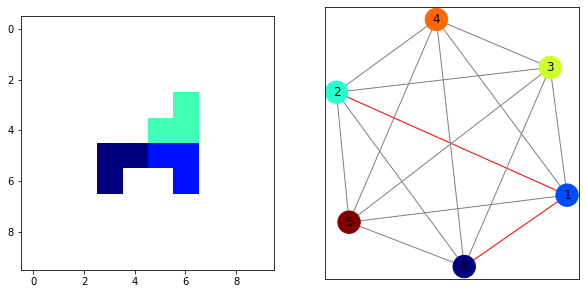

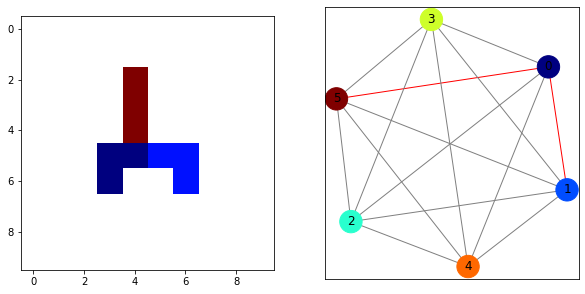

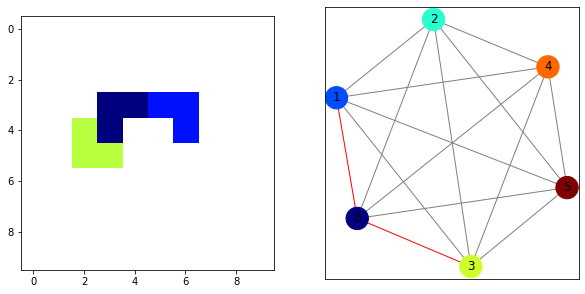

In [10]:
# display silhouette
for idx in range(10):
    s = np.copy(silhouettes[idx])
    show_silhouette_and_graph(s)
    print("\n\n\n")

<br><br><br><br><br>

## CNN

In [11]:
def build_weight_matrix(s):
    weights = np.zeros((6,6))
    for c in build_graph(s):
        x,y = c
        weights[x,y] = 1
        weights[y,x] = 1
    return weights

[[0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


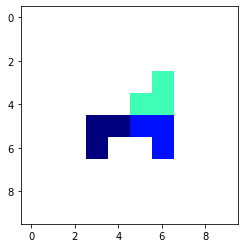

In [12]:
idx = 7
s = np.copy(silhouettes[idx])
b = get_binary_silhouette(s)
weights = build_weight_matrix(s)

draw_silhouette_color(get_bb_ids(s))
print(weights)

In [13]:
X = [s for s in silhouettes]
y = [build_weight_matrix(s) for s in silhouettes]

In [14]:
X_train_ids, X_test_ids, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train = [get_binary_silhouette(x) for x in X_train_ids]
X_test = [get_binary_silhouette(x) for x in X_test_ids]

In [15]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
       
        #Encoder
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  
        self.conv2 = nn.Conv2d(16, 4, 3, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
       
        #Decoder
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 1, stride=1)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.t_conv1(x))
        x = self.t_conv2(x)
              
        return x

In [16]:
model = ConvAutoencoder()

In [17]:
train_data = [(X_train[i], y_train[i]) for i in range(len(X_train))]
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=False)

In [18]:
#Loss function
criterion = nn.MSELoss()

#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [19]:
# n_epochs = 5000
# loss_history = []

# for epoch in range(1, n_epochs+1):
#     train_loss = 0.0

#     #Training
#     for data in train_dataloader:
#         X_batch, y_batch = data
#         X_batch = torch.tensor(X_batch.reshape(len(X_batch),1,10,10)).float()
#         y_batch = torch.tensor(y_batch.reshape(len(X_batch),1,6,6)).float()
        
#         optimizer.zero_grad()
#         outputs = model(X_batch)
        
#         loss = criterion(outputs, y_batch)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()
    
#     train_loss = train_loss/len(train_dataloader)
#     loss_history.append(train_loss)
#     if epoch % 100 ==0:
#         print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

In [20]:
# idx = 3
# s = np.copy(silhouettes[idx])
# b = get_binary_silhouette(s)
# b = b.reshape(1,1,10,10)
# b = torch.tensor(b).float()


# y_hat = model.forward(b)
# y_hat[y_hat<0.5]=0
# y_hat[y_hat>=0.5]=1
# print(y_hat)

# y_hat = y_hat.detach().numpy()
# y_hat = y_hat.reshape(6,6)
# con = [(c[0], c[1]) for c in np.argwhere(y_hat==1)]

In [21]:
def show_pred_and_gt(s, y_hat):
    fig = plt.figure(figsize=(18,5))
    fig.add_subplot(1,3,1)
    draw_silhouette_color(get_bb_ids(s))
    #plt.imshow(get_bb_ids(s))

    fig.add_subplot(1,3,2)
    all_edges = get_fully_connected_graph()
    G = nx.Graph()
    G.add_edges_from(all_edges)
    pos = nx.spring_layout(G)
    con_edges = build_graph(s)
    values = list(range(6))

    pos = nx.spring_layout(G)
    inactive = [edge for edge in G.edges() if edge not in con_edges]
    nx.draw_networkx_nodes(G, pos,  node_color = values, node_size = 500, cmap=plt.get_cmap('jet'))
    nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_edges(G, pos, edgelist=con_edges, edge_color='r')
    nx.draw_networkx_edges(G, pos, edgelist=inactive, edge_color='gray')
    
    
    
    
    fig.add_subplot(1,3,3)
    y_hat = y_hat.detach().numpy()
    y_hat = y_hat.reshape(6,6)
    con = [(c[0], c[1]) for c in np.argwhere(y_hat==1)]
    all_edges = get_fully_connected_graph()
    G = nx.Graph()
    G.add_edges_from(all_edges)
    pos = nx.spring_layout(G)
    con_edges = set(tuple(sorted(e)) for e in con)
    values = list(range(6))

    pos = nx.spring_layout(G)
    inactive = [edge for edge in G.edges() if edge not in con_edges]
    nx.draw_networkx_nodes(G, pos,  node_color = values, node_size = 500, cmap=plt.get_cmap('jet'))
    nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_edges(G, pos, edgelist=con_edges, edge_color='r')
    nx.draw_networkx_edges(G, pos, edgelist=inactive, edge_color='gray')
    
    

    plt.show()

In [22]:
# # display silhouette
# for idx in range(10):
#     s = np.copy(silhouettes[idx])
#     b = get_binary_silhouette(s)
#     b = b.reshape(1,1,10,10)
#     b = torch.tensor(b).float()
#     y_hat = model.forward(b)
#     y_hat[y_hat<0.5]=0
#     y_hat[y_hat>=0.5]=1
#     show_pred_and_gt(s, y_hat)
#     print("\n\n\n")

In [23]:
# # display silhouette
# for idx in range(10):
#     s = np.copy(X_test_ids[idx])
#     b = get_binary_silhouette(s)
#     b = b.reshape(1,1,10,10)
#     b = torch.tensor(b).float()
#     y_hat = model.forward(b)
#     y_hat[y_hat<0.5]=0
#     y_hat[y_hat>=0.5]=1
#     show_pred_and_gt(s, y_hat)
#     print("\n\n\n")

In [24]:
def get_accuracy(model, X, threshold):
    correct = 0
    for x in X:
        b = get_binary_silhouette(x)
        b = b.reshape(1,1,10,10)
        b = torch.tensor(b).float()
        y_hat = model.forward(b)
        y_hat[y_hat<threshold]=0
        y_hat[y_hat>=threshold]=1
        y_hat = y_hat.reshape(6,6).detach().numpy()
        y = build_weight_matrix(x)
        if np.allclose(y,y_hat):
            correct +=1
    print("Correct: ",correct,"/",len(X),"  -->", correct/len(X))
    
        
    

In [25]:
# for t in range(0,10,1):
#     t /= 10
#     print("\n## ",t,"##")
#     get_accuracy(model, X_test_ids, t)

<br><br><br><br><br><br><br>

# DQN

In [26]:
def show_adjacency_matrix(a):
    
    con = [(c[0], c[1]) for c in np.argwhere(a==1)]
    all_edges = get_fully_connected_graph()
    G = nx.Graph()
    G.add_edges_from(all_edges)
    pos = nx.spring_layout(G)
    con_edges = set(tuple(sorted(e)) for e in con)
    values = list(range(6))

    pos = nx.spring_layout(G)
    inactive = [edge for edge in G.edges() if edge not in con_edges]
    nx.draw_networkx_nodes(G, pos,  node_color = values, node_size = 500, cmap=plt.get_cmap('jet'))
    nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_edges(G, pos, edgelist=con_edges, edge_color='r')
    nx.draw_networkx_edges(G, pos, edgelist=inactive, edge_color='gray')
    
    #lt.show()

In [27]:
from env import Environment
from deep_q_agent import Agent

In [28]:
env = Environment(X_train, y_train)

In [29]:
sil, state = env.reset()
print(sil)
print(state)
print(env.current_gt)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
[[0. 1. 0. 0. 1. 0.]
 [1. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


In [33]:
gamma = 0.99
epsilon = 1.0
batch_size = 64
n_actions = 37
eps_end = 0.01
input_dims=(2, 10, 10)
lr = 0.003
score_history = []
eps_history = []
agent = Agent(gamma=gamma, epsilon = epsilon, batch_size = batch_size, eps_end = eps_end, input_dims = input_dims, lr = lr, n_action = n_actions)

In [34]:
n_games = 100000
reward_history = []
stat = []
for i in range(n_games):
    sil, state = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = agent.choose_action(sil,state, env.chosen_action)
        (next_sil,next_state),reward,done = env.step(action)
        #print(action, reward)
        total_reward += reward
        agent.store_transition(sil, state, action, reward, next_sil, next_state, done)
        agent.learn()
        sil = next_sil
        state = next_state
    stat.append(total_reward)
    if i % 100==0:
        print("Game #", i, "reward: ", np.mean(stat), "   eps: ",agent.epsilon)
        reward_history.append(np.mean(stat))
        stat = []
        
    
    
        

Game # 0 reward:  -1.0    eps:  1.0
Game # 100 reward:  -2.07    eps:  0.9993250000000056
Game # 200 reward:  -2.28    eps:  0.9984460000000128
Game # 300 reward:  -2.28    eps:  0.9975640000000201
Game # 400 reward:  -2.46    eps:  0.9966790000000274
Game # 500 reward:  -2.35    eps:  0.9957910000000347
Game # 600 reward:  -2.09    eps:  0.9949420000000417
Game # 700 reward:  -2.37    eps:  0.994063000000049
Game # 800 reward:  -2.06    eps:  0.9932020000000561
Game # 900 reward:  -1.97    eps:  0.9923350000000632
Game # 1000 reward:  -2.06    eps:  0.9914590000000705
Game # 1100 reward:  -2.05    eps:  0.9905950000000776
Game # 1200 reward:  -2.2    eps:  0.9897190000000848
Game # 1300 reward:  -2.22    eps:  0.9888340000000921
Game # 1400 reward:  -2.03    eps:  0.9879610000000993
Game # 1500 reward:  -2.14    eps:  0.9870760000001066
Game # 1600 reward:  -2.22    eps:  0.9862150000001138
Game # 1700 reward:  -2.07    eps:  0.9853720000001207
Game # 1800 reward:  -2.09    eps:  0.98

Game # 15000 reward:  -1.69    eps:  0.8692330000010791
Game # 15100 reward:  -1.74    eps:  0.8683480000010864
Game # 15200 reward:  -1.99    eps:  0.8674690000010936
Game # 15300 reward:  -1.73    eps:  0.8665810000011009
Game # 15400 reward:  -1.7    eps:  0.8657140000011081
Game # 15500 reward:  -1.65    eps:  0.8648290000011154
Game # 15600 reward:  -1.59    eps:  0.8639710000011225
Game # 15700 reward:  -1.57    eps:  0.8631160000011295
Game # 15800 reward:  -1.74    eps:  0.8622550000011366
Game # 15900 reward:  -1.59    eps:  0.8613760000011439
Game # 16000 reward:  -1.64    eps:  0.860512000001151
Game # 16100 reward:  -1.5    eps:  0.8596570000011581
Game # 16200 reward:  -1.78    eps:  0.8587900000011652
Game # 16300 reward:  -1.56    eps:  0.8579230000011724
Game # 16400 reward:  -1.68    eps:  0.8570740000011794
Game # 16500 reward:  -1.57    eps:  0.8562160000011865
Game # 16600 reward:  -1.42    eps:  0.8553490000011936
Game # 16700 reward:  -1.56    eps:  0.854497000001

Game # 29700 reward:  -1.33    eps:  0.7414990000021331
Game # 29800 reward:  -1.28    eps:  0.7406290000021403
Game # 29900 reward:  -1.34    eps:  0.7397530000021475
Game # 30000 reward:  -1.2    eps:  0.7388740000021548
Game # 30100 reward:  -1.29    eps:  0.737989000002162
Game # 30200 reward:  -1.35    eps:  0.7371100000021693
Game # 30300 reward:  -1.18    eps:  0.7362370000021765
Game # 30400 reward:  -1.12    eps:  0.7353520000021838
Game # 30500 reward:  -1.24    eps:  0.734485000002191
Game # 30600 reward:  -1.39    eps:  0.7336240000021981
Game # 30700 reward:  -1.35    eps:  0.7327420000022054
Game # 30800 reward:  -1.12    eps:  0.7318810000022125
Game # 30900 reward:  -1.27    eps:  0.7310110000022196
Game # 31000 reward:  -1.06    eps:  0.7301500000022267
Game # 31100 reward:  -1.1    eps:  0.7292800000022339
Game # 31200 reward:  -1.22    eps:  0.7284010000022412
Game # 31300 reward:  -1.37    eps:  0.7275160000022485
Game # 31400 reward:  -1.4    eps:  0.72663400000225

Game # 44400 reward:  -0.8    eps:  0.6145000000031811
Game # 44500 reward:  -0.72    eps:  0.6136480000031881
Game # 44600 reward:  -0.83    eps:  0.6127810000031952
Game # 44700 reward:  -0.59    eps:  0.6119290000032023
Game # 44800 reward:  -0.66    eps:  0.6110650000032094
Game # 44900 reward:  -0.85    eps:  0.6101920000032166
Game # 45000 reward:  -0.91    eps:  0.6093190000032238
Game # 45100 reward:  -0.52    eps:  0.6084640000032309
Game # 45200 reward:  -0.86    eps:  0.6075880000032381
Game # 45300 reward:  -0.75    eps:  0.6067120000032453
Game # 45400 reward:  -0.62    eps:  0.6058390000032525
Game # 45500 reward:  -0.88    eps:  0.6049450000032599
Game # 45600 reward:  -0.87    eps:  0.6040600000032672
Game # 45700 reward:  -0.72    eps:  0.6031900000032744
Game # 45800 reward:  -0.94    eps:  0.6023200000032816
Game # 45900 reward:  -0.89    eps:  0.6014380000032888
Game # 46000 reward:  -0.8    eps:  0.600571000003296
Game # 46100 reward:  -0.96    eps:  0.599707000003

Game # 59100 reward:  -0.51    eps:  0.48739000000422994
Game # 59200 reward:  -0.46    eps:  0.4865230000042371
Game # 59300 reward:  -0.44    eps:  0.4856620000042442
Game # 59400 reward:  -0.3    eps:  0.4848130000042512
Game # 59500 reward:  -0.7    eps:  0.48394600000425836
Game # 59600 reward:  -0.64    eps:  0.48306100000426566
Game # 59700 reward:  -0.62    eps:  0.4821940000042728
Game # 59800 reward:  -0.32    eps:  0.48135400000427975
Game # 59900 reward:  -0.73    eps:  0.48049300000428685
Game # 60000 reward:  -0.52    eps:  0.4796380000042939
Game # 60100 reward:  -0.71    eps:  0.4787560000043012
Game # 60200 reward:  -0.41    eps:  0.47789800000430827
Game # 60300 reward:  -0.55    eps:  0.4770220000043155
Game # 60400 reward:  -0.61    eps:  0.4761850000043224
Game # 60500 reward:  -0.61    eps:  0.47532100000432953
Game # 60600 reward:  -0.56    eps:  0.47444800000433673
Game # 60700 reward:  -0.62    eps:  0.4735780000043439
Game # 60800 reward:  -0.62    eps:  0.472

Game # 73700 reward:  -0.39    eps:  0.3623560000052617
Game # 73800 reward:  -0.4    eps:  0.36148600000526887
Game # 73900 reward:  -0.49    eps:  0.3606310000052759
Game # 74000 reward:  -0.46    eps:  0.3597610000052831
Game # 74100 reward:  0.02    eps:  0.35892400000529
Game # 74200 reward:  -0.24    eps:  0.35806900000529707
Game # 74300 reward:  -0.25    eps:  0.3572380000053039
Game # 74400 reward:  -0.32    eps:  0.3563920000053109
Game # 74500 reward:  0.0    eps:  0.35557300000531766
Game # 74600 reward:  -0.41    eps:  0.3547180000053247
Game # 74700 reward:  -0.34    eps:  0.3538750000053317
Game # 74800 reward:  -0.41    eps:  0.3529990000053389
Game # 74900 reward:  -0.49    eps:  0.35214400000534596
Game # 75000 reward:  -0.43    eps:  0.35129500000535296
Game # 75100 reward:  -0.3    eps:  0.35044900000535995
Game # 75200 reward:  -0.39    eps:  0.349597000005367
Game # 75300 reward:  -0.34    eps:  0.3487330000053741
Game # 75400 reward:  0.13    eps:  0.347929000005

Game # 88400 reward:  -0.2    eps:  0.23662600000617545
Game # 88500 reward:  -0.11    eps:  0.2357680000061746
Game # 88600 reward:  -0.37    eps:  0.2348860000061737
Game # 88700 reward:  -0.19    eps:  0.23401900000617284
Game # 88800 reward:  -0.46    eps:  0.23314600000617197
Game # 88900 reward:  -0.12    eps:  0.23230300000617113
Game # 89000 reward:  -0.27    eps:  0.23144500000617027
Game # 89100 reward:  -0.4    eps:  0.23055400000616938
Game # 89200 reward:  -0.48    eps:  0.2296810000061685
Game # 89300 reward:  -0.36    eps:  0.22879300000616762
Game # 89400 reward:  -0.43    eps:  0.22792300000616675
Game # 89500 reward:  -0.38    eps:  0.22703500000616586
Game # 89600 reward:  -0.3    eps:  0.226180000006165
Game # 89700 reward:  -0.3    eps:  0.22532200000616415
Game # 89800 reward:  -0.23    eps:  0.2244670000061633
Game # 89900 reward:  -0.17    eps:  0.22360900000616243
Game # 90000 reward:  -0.38    eps:  0.22273600000616156
Game # 90100 reward:  -0.38    eps:  0.22

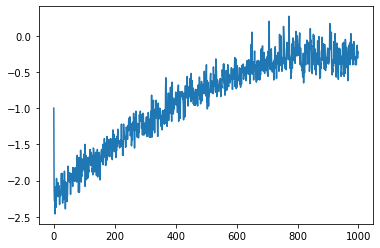

In [35]:
plt.plot(reward_history)




##### GAME  0  #####


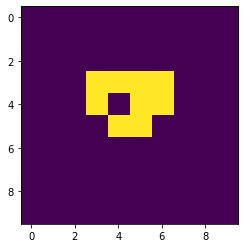

action:  1    reward:  1
action:  21    reward:  -1
action:  25    reward:  -1


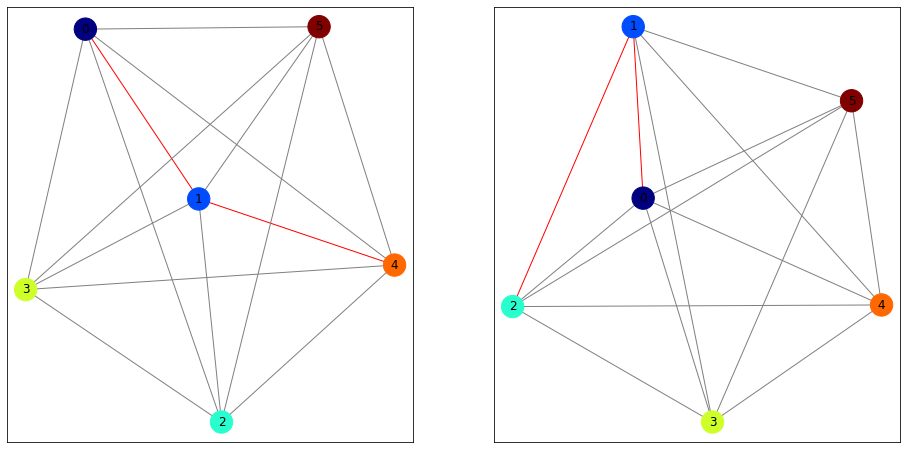




##### GAME  1  #####


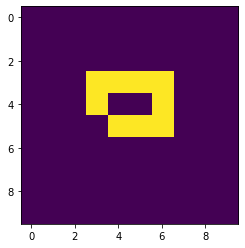

action:  1    reward:  1
action:  21    reward:  -1
action:  25    reward:  1


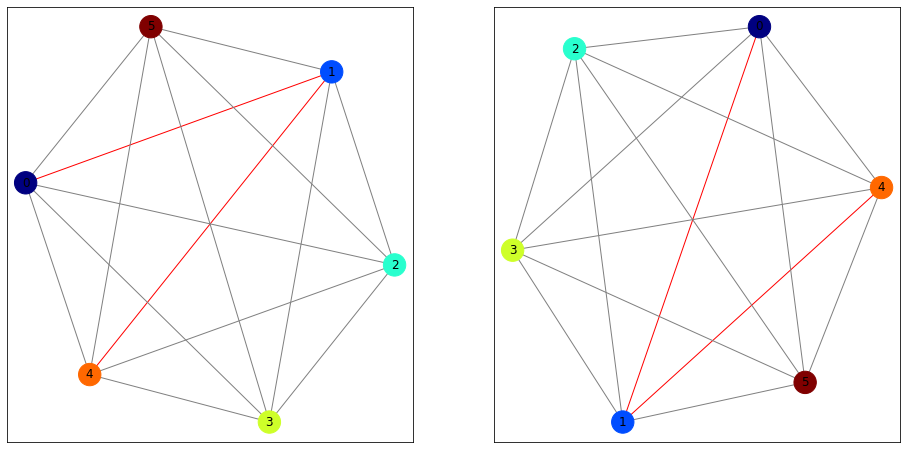




##### GAME  2  #####


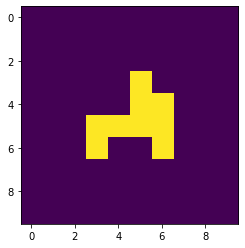

action:  1    reward:  1
action:  21    reward:  -1
action:  25    reward:  -1


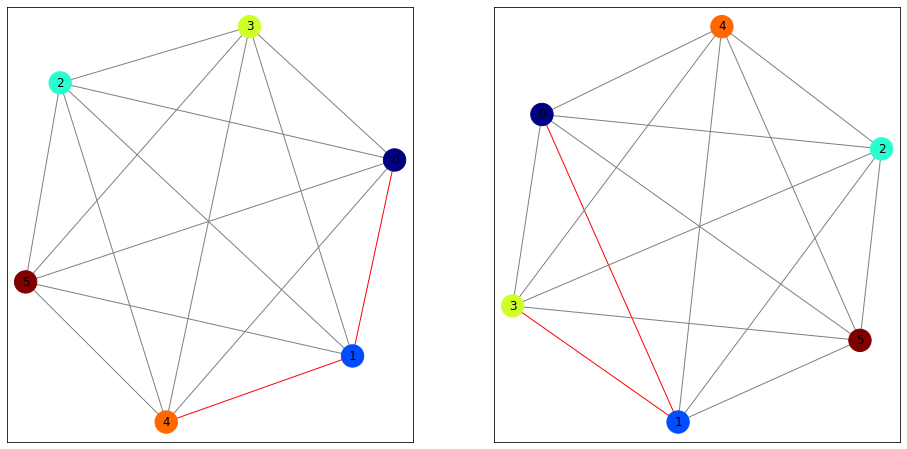




##### GAME  3  #####


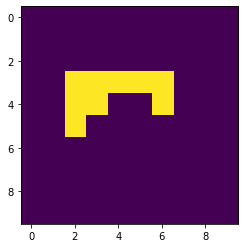

action:  1    reward:  1
action:  21    reward:  -1
action:  25    reward:  -1


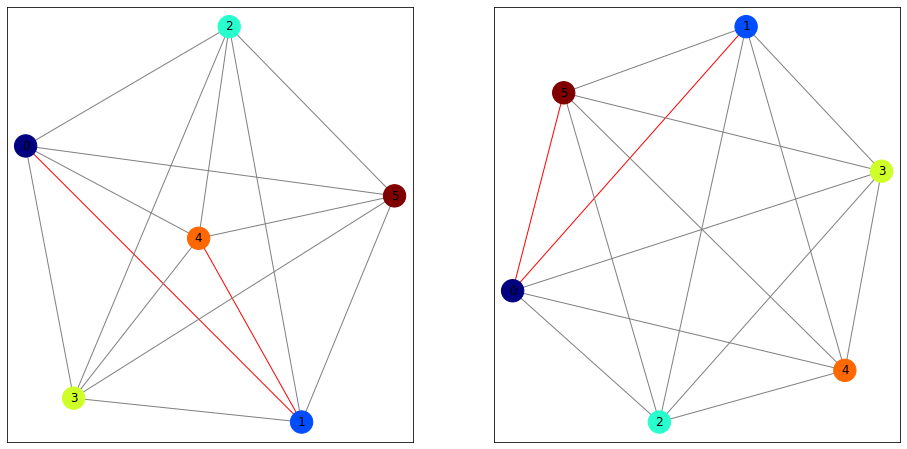




##### GAME  4  #####


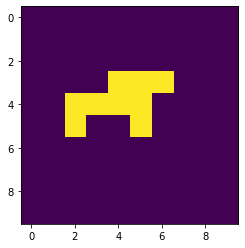

action:  1    reward:  1
action:  21    reward:  -1
action:  25    reward:  1


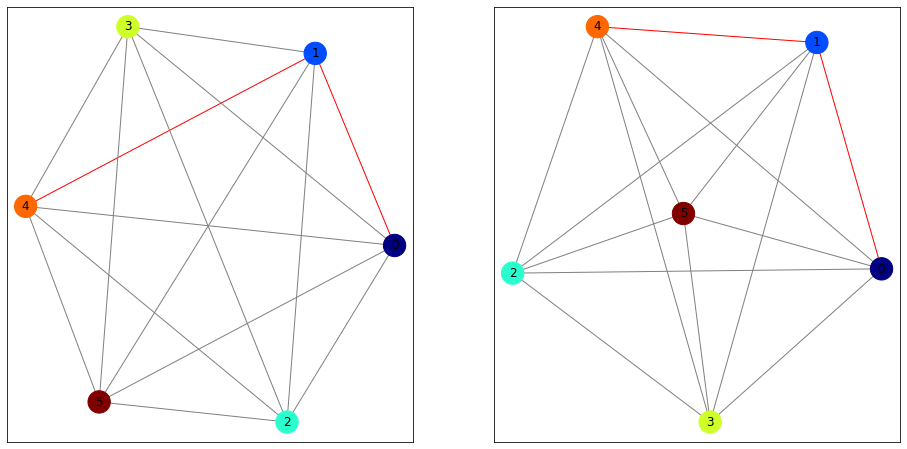




##### GAME  5  #####


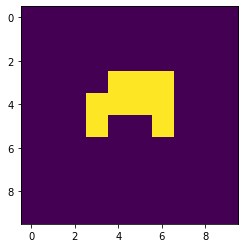

action:  1    reward:  1
action:  21    reward:  -1
action:  25    reward:  1


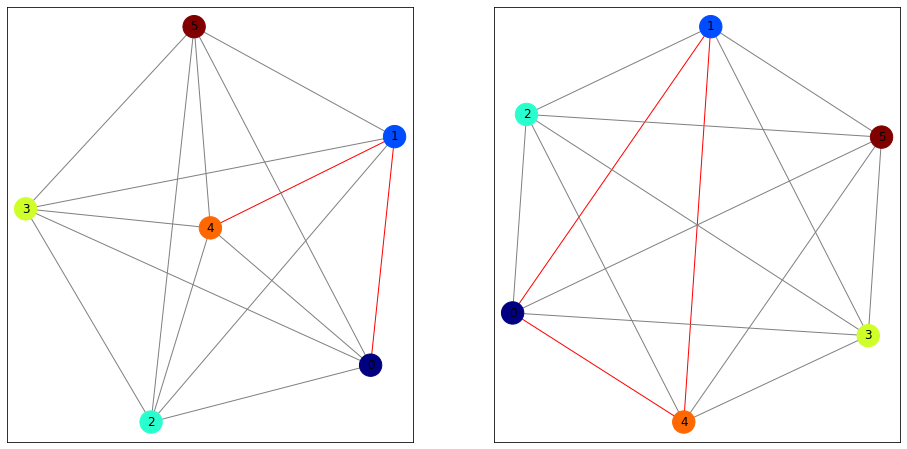




##### GAME  6  #####


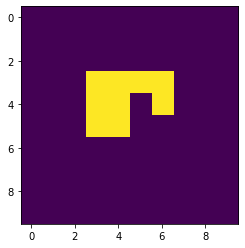

action:  1    reward:  1
action:  21    reward:  -1
action:  25    reward:  -1


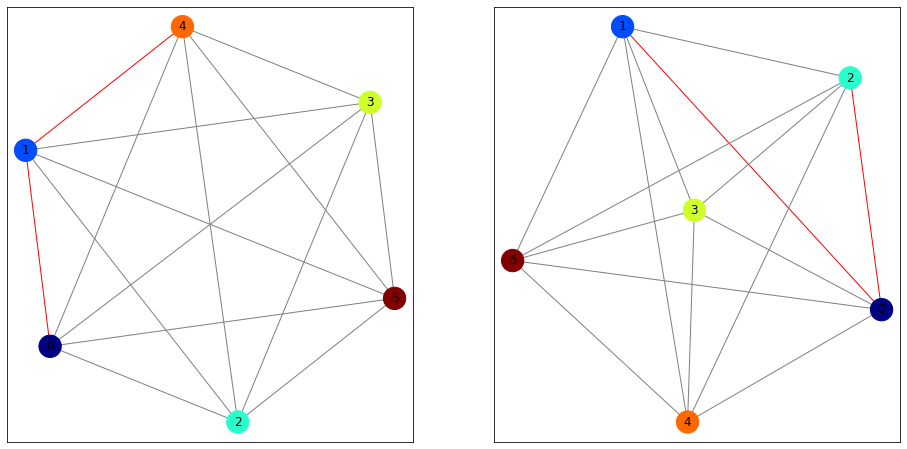




##### GAME  7  #####


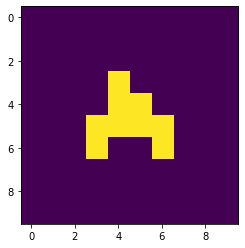

action:  1    reward:  1
action:  21    reward:  -1
action:  25    reward:  -1


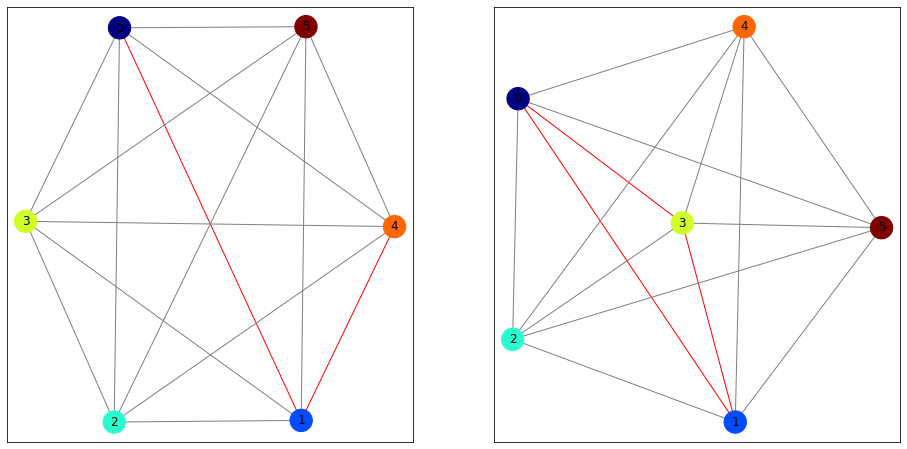




##### GAME  8  #####


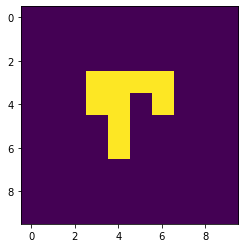

action:  1    reward:  1
action:  21    reward:  -1
action:  25    reward:  -1


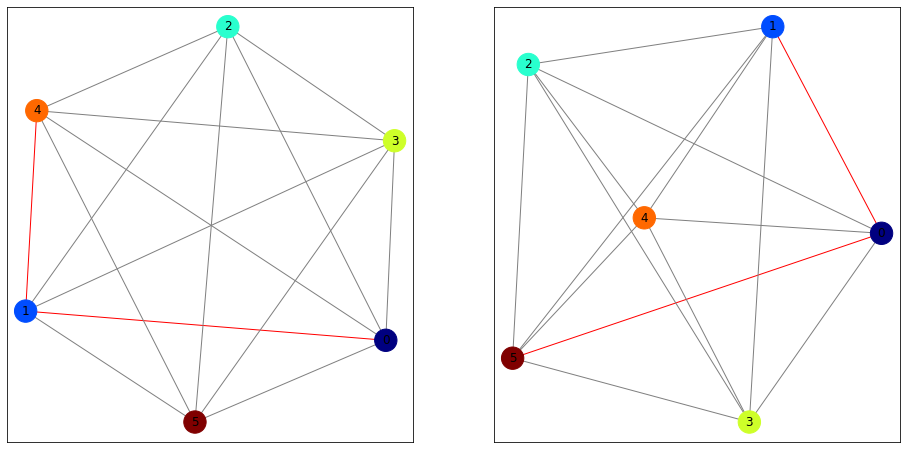




##### GAME  9  #####


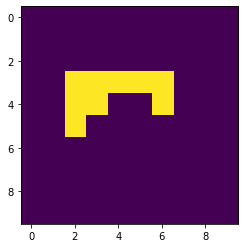

action:  1    reward:  1
action:  21    reward:  -1
action:  25    reward:  -1


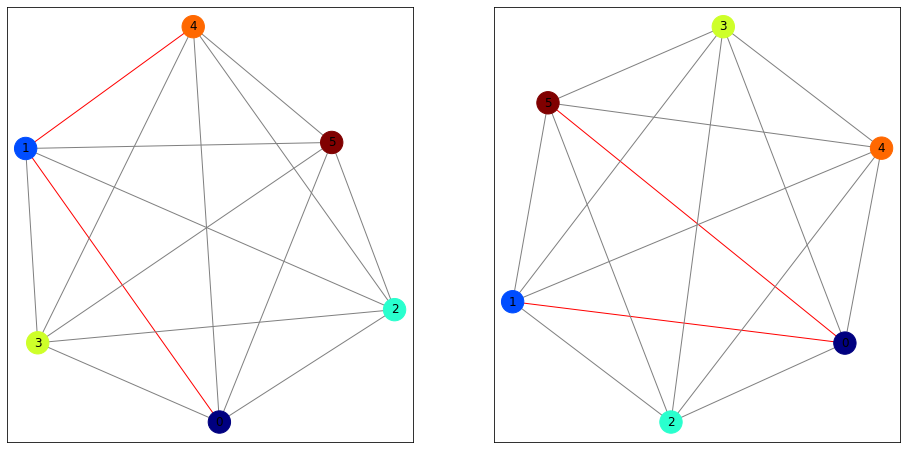




##### GAME  10  #####


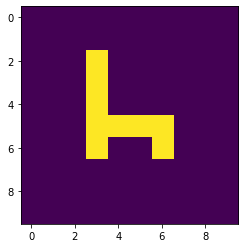

action:  1    reward:  1
action:  21    reward:  -1
action:  25    reward:  -1


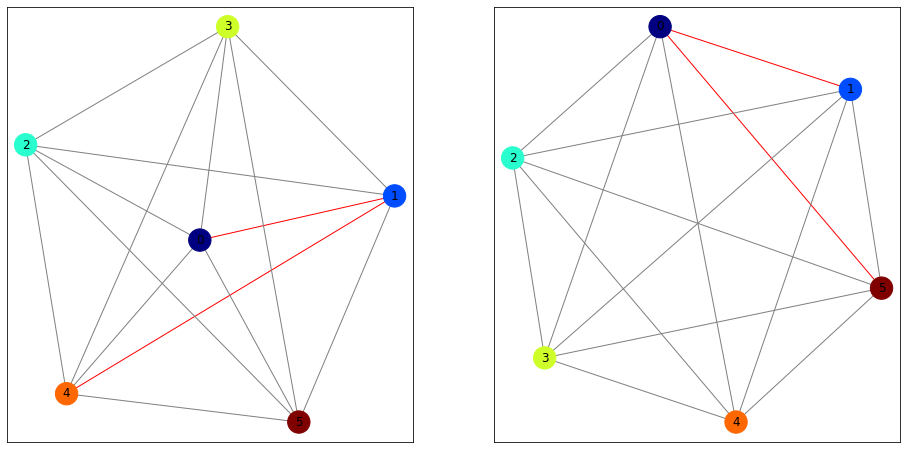




##### GAME  11  #####


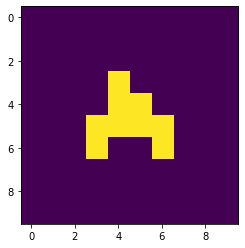

action:  1    reward:  1
action:  21    reward:  -1
action:  25    reward:  -1


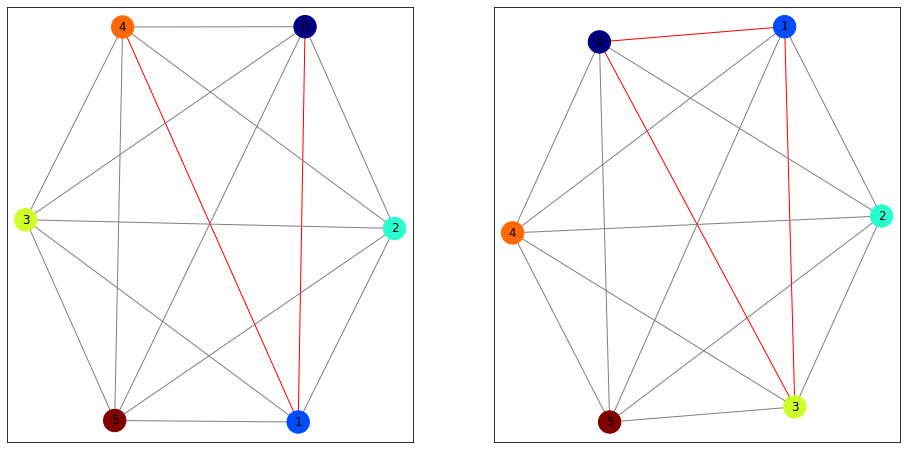




##### GAME  12  #####


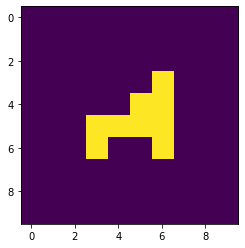

action:  1    reward:  1
action:  21    reward:  -1
action:  25    reward:  -1


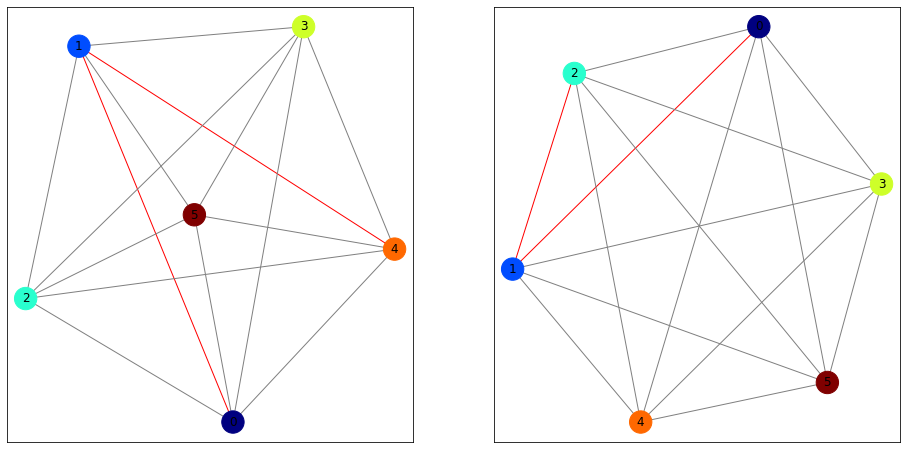




##### GAME  13  #####


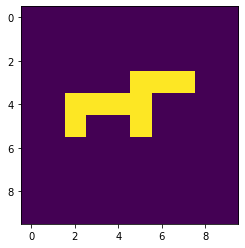

action:  1    reward:  1
action:  21    reward:  -1
action:  25    reward:  1


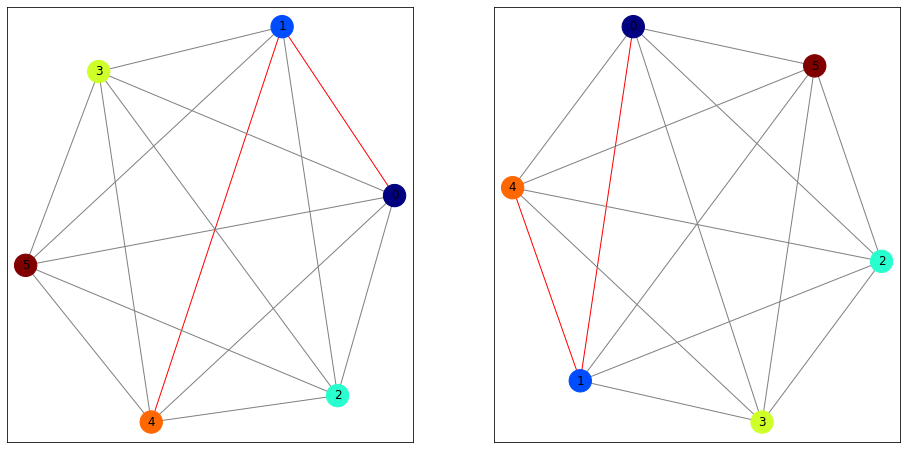




##### GAME  14  #####


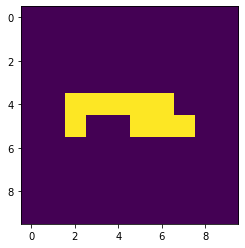

action:  1    reward:  1
action:  21    reward:  -1
action:  25    reward:  -1


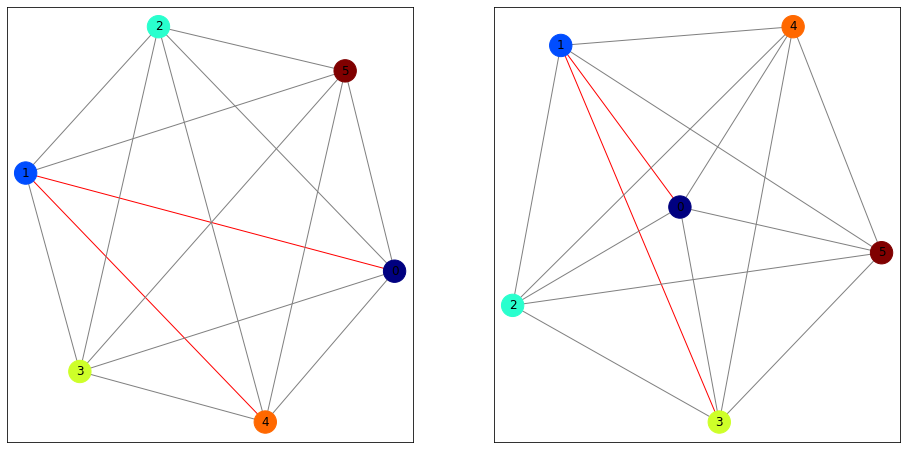




##### GAME  15  #####


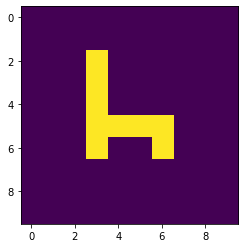

action:  1    reward:  1
action:  21    reward:  -1
action:  25    reward:  -1


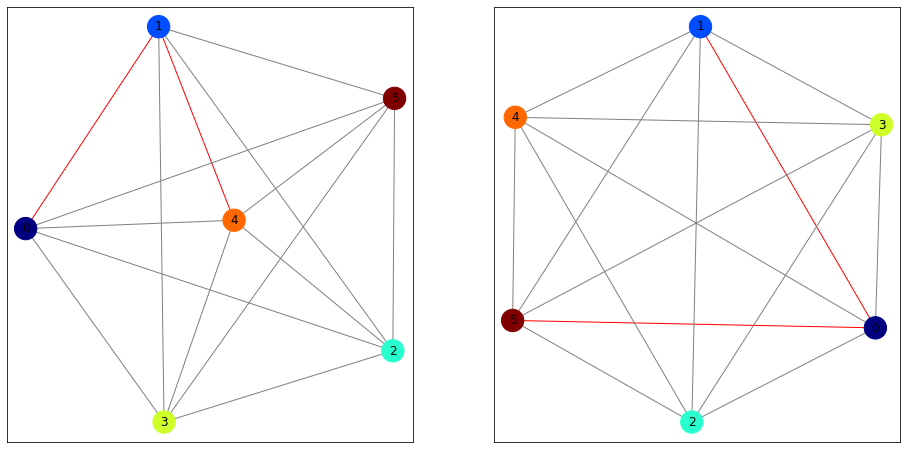




##### GAME  16  #####


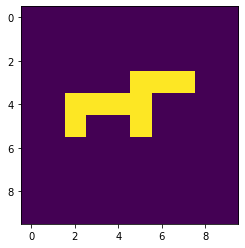

action:  1    reward:  1
action:  21    reward:  -1
action:  25    reward:  1


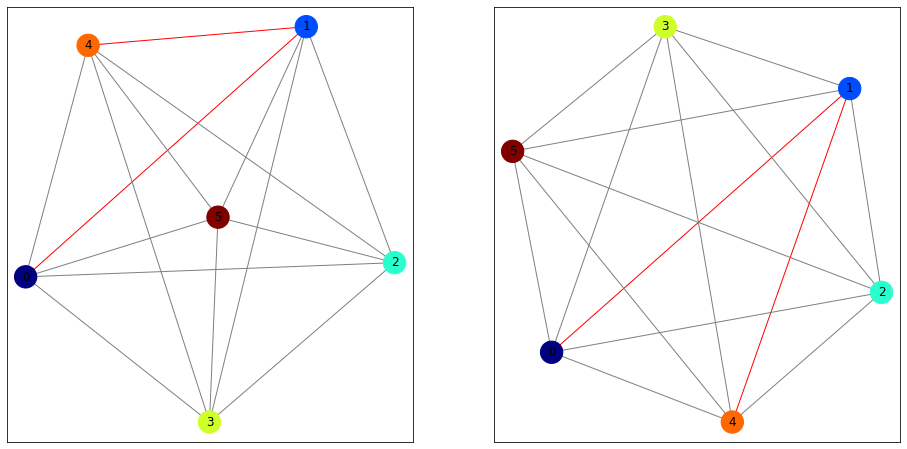




##### GAME  17  #####


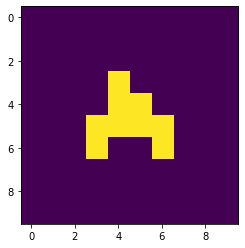

action:  1    reward:  1
action:  21    reward:  -1
action:  25    reward:  -1


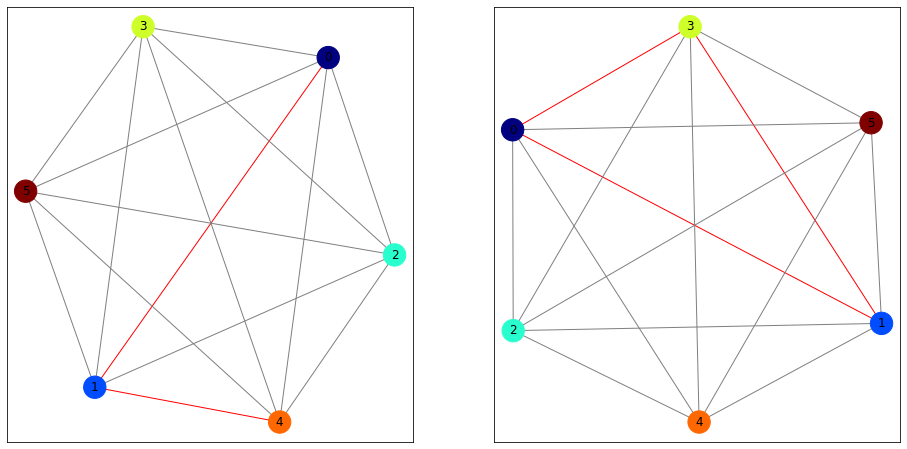




##### GAME  18  #####


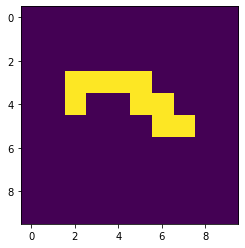

action:  1    reward:  1
action:  21    reward:  -1
action:  25    reward:  -1


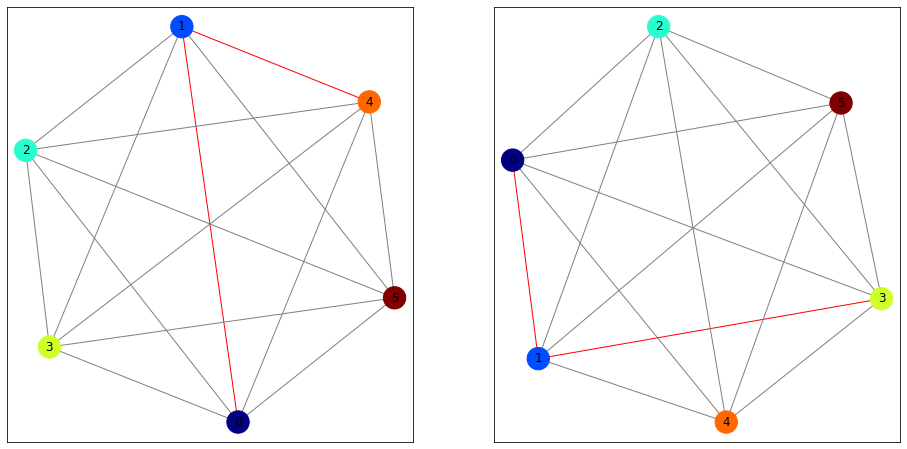




##### GAME  19  #####


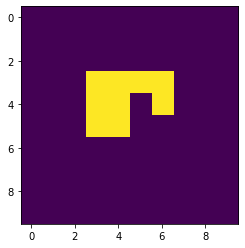

action:  1    reward:  1
action:  21    reward:  -1
action:  25    reward:  -1


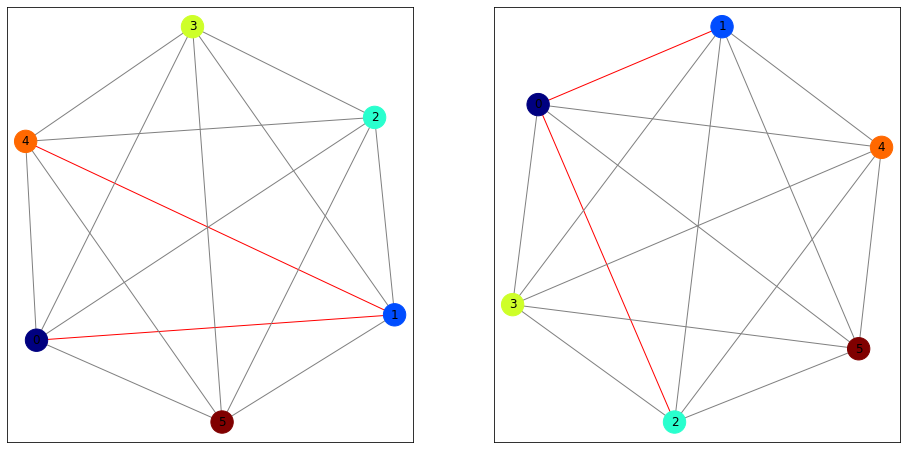

In [36]:
agent.epsilon = 0
env = Environment(X_test, y_test)
for i in range(20):
    print("\n\n\n##### GAME ",i," #####")
    sil, state = env.reset()
    done = False
    total_reward = 0
    plt.imshow(sil)
    plt.show()
    while not done:
        action = agent.choose_action(sil,state, env.chosen_action)
        (next_sil,next_state),reward,done = env.step(action)
        total_reward += reward
        sil = next_sil
        state = next_state
        print("action: ",action, "   reward: ", reward)
    
    fig = plt.figure(figsize=(16,8))
    fig.add_subplot(1,2,1)
    y_hat = env.adjacency
    show_adjacency_matrix(y_hat)
    fig.add_subplot(1,2,2)
    y = env.current_gt
    show_adjacency_matrix(y)
    plt.show()
    
    